In [ ]:
# Предсказание курса акций VipShop

# Данные возьмем из доступных ресурсов
# Для сравния результатов моделирования выберем метрику RMSE
# Попробуем сделать предсказание курса акции за последние 30 дней

#Парсинг данных

In [ ]:
# Парсинг данных

#!pip install yfinance

#import yfinance as yf
#data = yf.download('VIPS','2012-10-31','2021-11-26')
#print(data.tail(10))

# Сохраним данные на диск для удобства, в дальнейшем будем загружать их оттуда:

#data.to_csv('VIPS.csv')
#!cp VIPS.csv "/content/drive/MyDrive/Stock_price_pred/"

In [1]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 50 kB/s 


In [2]:
#Загрузим необходимые для работы библиотеки:
import math
import numpy
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('fivethirtyeight')

In [3]:
# Загрузим наши данные:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATA_DIR = '/content/drive/MyDrive/Stock_price_pred/'
df = pd.read_csv(DATA_DIR+'VIPS.csv')

#EDA

In [5]:
# Ознакомимся с датасетом
df.tail(30)

,Date,Open,High,Low,Close,Adj Close,Volume
2254,2021-10-14,11.51,11.58,11.16,11.32,11.32,6237000
2255,2021-10-15,11.46,11.92,11.23,11.47,11.47,9456500
2256,2021-10-18,11.43,11.67,11.28,11.45,11.45,4852300
2257,2021-10-19,11.68,12.49,11.62,12.42,12.42,11446200
2258,2021-10-20,12.60,13.32,12.46,12.50,12.50,13220600
2259,2021-10-21,12.45,12.95,12.42,12.78,12.78,5696400
2260,2021-10-22,12.73,13.00,12.36,12.46,12.46,5531400
2261,2021-10-25,12.55,12.70,12.00,12.46,12.46,5802400
2262,2021-10-26,12.51,12.51,11.62,11.88,11.88,9228000
2263,2021-10-27,11.71,12.15,11.55,11.68,11.68,6904600


In [41]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-10-31,1.000,1.010,0.985,1.003,1.003,710000
1,2012-11-01,1.025,1.028,0.997,1.025,1.025,341000
2,2012-11-02,1.030,1.030,1.021,1.025,1.025,274000
3,2012-11-05,1.021,1.046,1.011,1.013,1.013,833000
4,2012-11-06,1.010,1.049,0.990,1.025,1.025,1233000


In [ ]:
# Для моделирования будем использовать колонку Close нас будет интересовать цена акций на момент закрытия биржи

In [42]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [43]:
df.Close.describe()

count    2284.000000
mean       13.950809
std         7.373549
min         1.003000
25%         8.420000
50%        13.195000
75%        18.142499
max        45.580002
Name: Close, dtype: float64

In [8]:
df1 = df.reset_index()['Close']

In [44]:
df1.tail()

2279    10.03
2280    10.04
2281    10.15
2282     9.65
2283    10.31
Name: Close, dtype: float64

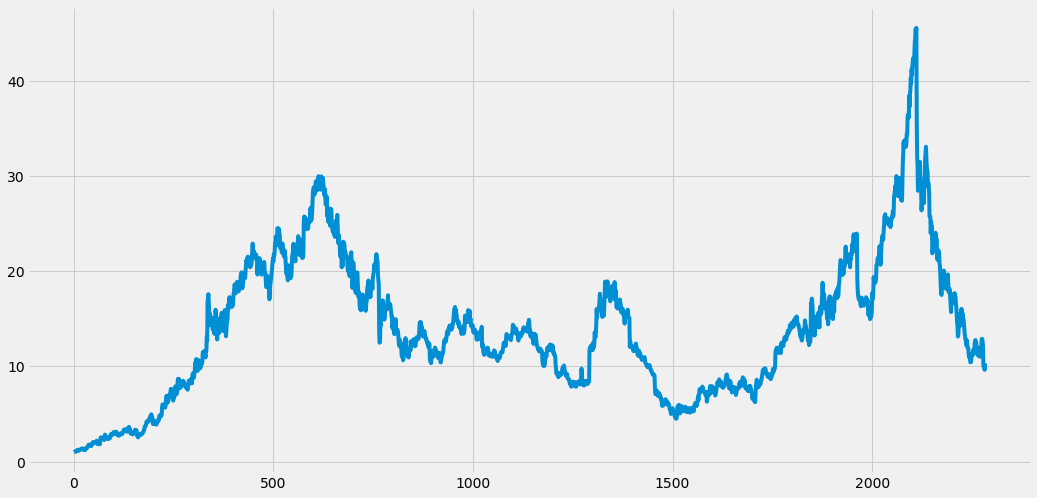

In [45]:
# Построим график как изменялясь цена акции по дням
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
df1.plot()

In [46]:
# Разделим данные на трейн, и отделим данные для предсказания за последние 30 дней

df2 = df1[:len(df1)-30]

In [47]:
df2

0        1.003
1        1.025
2        1.025
3        1.013
4        1.025
         ...  
2249    11.020
2250    11.300
2251    11.180
2252    11.240
2253    11.700
Name: Close, Length: 2254, dtype: float64

In [48]:
df2 = np.array(df2).reshape(-1,1)

In [49]:
df2


array([[ 1.00300002],
       [ 1.02499998],
       [ 1.02499998],
       ...,
       [11.18000031],
       [11.23999977],
       [11.69999981]])

In [50]:
# Нормализуем данные с помощью MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df2 = scaler.fit_transform(df2)

In [51]:
# Делим оставшиеся данные на трейн и валидацию в пропорции 0.65/0.35

training_size=int(len(df2)*0.65)
test_size=len(df2)-training_size
train_data,test_data=df2[0:training_size],df2[training_size:len(df2)]

In [52]:
training_size,test_size

(1465, 789)

Для построения моделей применим следующую логику
Введем понятие time_step - это будет шаг нашей целевой переменной для алгоритма. Допустим time_step=3, тогда фичи -это первые три значения цены акции, а 4-е значение будет целевой переменной. Далее сдвигаемся на один шаг. df2[2],df2[3],df2[4], это следующие значения наших фичей, а df2(5) - это следующее значение нашей целевой переменной. То есть наша целевая переменная это результат 3-х предыдущих дней.
В решении буду использовать time_step=100, то есть уелевая переменная будет зависеть от предыдущих 100 дней. Напишем функцию для реализации данной логики 

In [53]:
# Функция конвертирует наш массив данных в матрицу со столбцами фичей и столбцом целевой переменной
def create_dataset(dataset,time_step=1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0] ###i=0,1,2,3
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return numpy.array(dataX),numpy.array(dataY)

In [54]:
# Построим датасет X=t,t+1,t+2,t+3.... and Y=t+4
time_step = 100
X_train,y_train = create_dataset(train_data,time_step)
X_test,y_test = create_dataset(test_data,time_step)

Посмотрим какие размерности получились

In [55]:
print(X_train)

[[0.00000000e+00 4.93527027e-04 4.93527027e-04 ... 4.16806866e-02
  4.15909553e-02 4.44399548e-02]
 [4.93527027e-04 4.93527027e-04 2.24330710e-04 ... 4.15909553e-02
  4.44399548e-02 4.73113911e-02]
 [4.93527027e-04 2.24330710e-04 4.93527027e-04 ... 4.44399548e-02
  4.73113911e-02 4.56289081e-02]
 ...
 [3.50337622e-01 3.39569705e-01 3.38223732e-01 ... 1.37896221e-01
  1.37896221e-01 1.45747801e-01]
 [3.39569705e-01 3.38223732e-01 3.47196960e-01 ... 1.37896221e-01
  1.45747801e-01 1.41485512e-01]
 [3.38223732e-01 3.47196960e-01 3.46299659e-01 ... 1.45747801e-01
  1.41485512e-01 1.41261187e-01]]


In [56]:
print(y_train)

[0.04731139 0.04562891 0.04446239 ... 0.14148551 0.14126119 0.13453125]


In [57]:
print(X_train.shape), print(y_train.shape)

(1364, 100)
(1364,)


(None, None)

In [72]:
print(X_test.shape), print(y_test.shape)

(688, 100, 1)
(688,)


(None, None)

#Моделирование

#Модель LSTM

In [58]:
df2.shape

(2254, 1)

In [59]:
df2

array([[0.        ],
       [0.00049353],
       [0.00049353],
       ...,
       [0.22830159],
       [0.22964756],
       [0.23996678]])

In [60]:
# Cнабдим еще одной размерностью 
# для нейросети LSTM [samples,timesteps,features]
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [61]:
### Create LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from  tensorflow.keras.layers import LSTM

In [62]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer = 'adam')

In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [64]:
model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=10,batch_size=64,verbose=1 )

Epoch 1/10
22/22 [==============================] - 12s 276ms/step - loss: 0.0169 - val_loss: 0.0056
Epoch 2/10
22/22 [==============================] - 5s 219ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 3/10
22/22 [==============================] - 5s 214ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 4/10
22/22 [==============================] - 5s 248ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 5/10
22/22 [==============================] - 5s 220ms/step - loss: 9.7966e-04 - val_loss: 0.0028
Epoch 6/10
22/22 [==============================] - 5s 208ms/step - loss: 9.0758e-04 - val_loss: 0.0027
Epoch 7/10
22/22 [==============================] - 5s 209ms/step - loss: 8.9713e-04 - val_loss: 0.0026
Epoch 8/10
22/22 [==============================] - 5s 229ms/step - loss: 8.5595e-04 - val_loss: 0.0025
Epoch 9/10
22/22 [==============================] - 5s 214ms/step - loss: 8.0306e-04 - val_loss: 0.0024
Epoch 10/10
22/22 [==============================] - 6s 265ms/step - loss: 7.71

In [65]:
# Сделаем предсказание на трейне и на тесте
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
#test_predict

In [66]:
# Вернемся к начальной размерности данных
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [71]:
2254-1364


890

In [70]:
len(test_predict)

688

In [73]:
test_predict [670:]

array([[14.050877],
       [13.93925 ],
       [13.791364],
       [13.613714],
       [13.420478],
       [13.214711],
       [13.001446],
       [12.786407],
       [12.568649],
       [12.346366],
       [12.123643],
       [11.902746],
       [11.682165],
       [11.463553],
       [11.250615],
       [11.053884],
       [10.882979],
       [10.741148]], dtype=float32)

In [38]:
### Посчитаем метрику RMSE на трейне
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

15.230433204111256

In [39]:
### Посчитаем метрику RMSE на тесте
math.sqrt(mean_squared_error(y_test,test_predict))

18.43948023051257

In [74]:
### Посчитаем метрику MAPE на трейне
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_train,train_predict)

47.24578022155041

In [75]:
### Посчитаем метрику MAPE на тесте
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test,test_predict)

45.31537573189552

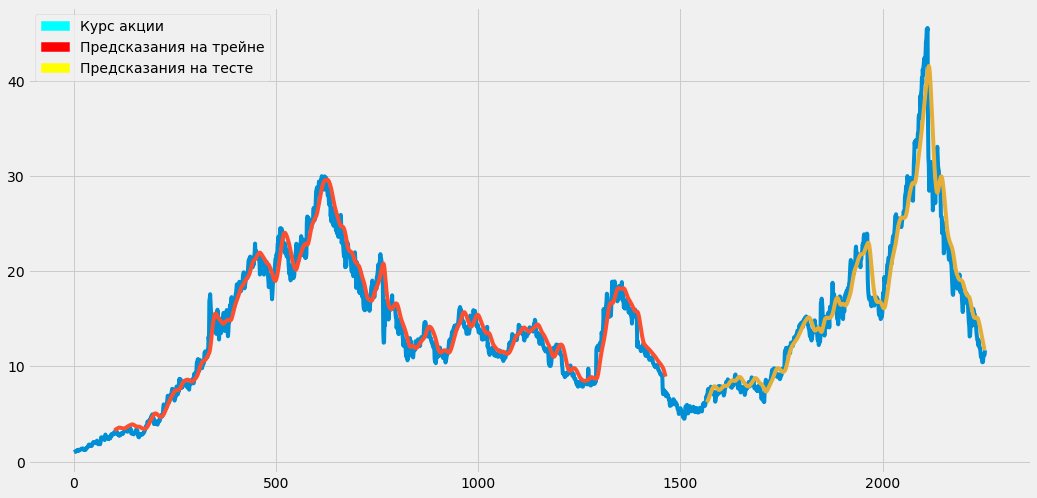

In [37]:
# Построим график нашего обучения и предсказания модели на тестовых данных
### Plotting
#Shift train predictions for plotting
plt.figure(figsize=(16,8))
look_back = 100
trainPredictPlot = numpy.empty_like(df2)
trainPredictPlot[:,:] =np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df2)
testPredictPlot[:,:] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df2)-1,:] = test_predict
#plot baseline and predictions
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='cyan', label='Курс акции')
red_patch = mpatches.Patch(color='red', label='Предсказания на трейне')
yellow_patch = mpatches.Patch(color='yellow', label='Предсказания на тесте')
plt.legend(handles=[blue_patch,red_patch,yellow_patch])
plt.show()


In [ ]:
# Попробуем сделать предсказание на 30 дней по следующей логике:
# Если time_step =100
# Берем последние 100 дней, по обученной модели предсказываем 101 день
# Добавляем его к данным, и сдвигаем эти 100 дней на одно значение
# Предсказываем следующий день, добавляем его к данным и сдвигаем 100 дней еще на одно значение
# Повторяем это 30 раз

In [76]:
len(test_data)

789

In [77]:
#Берем последние 100 дней
x_input = test_data[689:].reshape(1,-1)
x_input.shape

(1, 100)

In [78]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [161]:
# Получаем предсказания для 30 дней на основе последних 100 дней
from numpy import array
lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
      #print (temp input)
      x_input=np.array(temp_input[1:])
     # print("{} day input {}".format(i,x_input))
      x_input=x_input.reshape((1,n_steps, 1))
      #print (x_input)
      yhat = model.predict(x_input, verbose=0)
      #print("{} day output {}".format(i,yhat))
      temp_input.extend(yhat[0].tolist())
      temp_input = temp_input[1:]
      #print(temp_input)
      lst_output.extend(yhat.tolist())
      i=i+1
    else:
      x_input = x_input.reshape((1 , n_steps,1))
      yhat = model.predict(x_input, verbose=0)
     # print(yhat[0])
      temp_input.extend(yhat[0].tolist())
      #print(len(temp_input))
      lst_output.extend(yhat.tolist())
      i=i+1
#print(lst_output)


CatBoostError: ignored

In [80]:
day_new=np.arange(1,101)
day_pred = np.arange(101,131)

In [81]:
df3=df2.tolist()
df3.extend(lst_output)

In [160]:
df3[:10]

array([[1.00300002],
       [1.02499998],
       [1.02499998],
       [1.01300001],
       [1.02499998],
       [1.097     ],
       [1.15499997],
       [1.15699995],
       [1.11500001],
       [1.13300002]])

In [83]:
df2=scaler.fit_transform(np.array(df2).reshape(-1,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

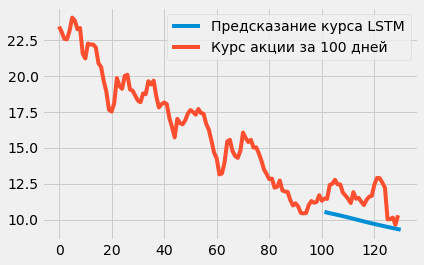

In [84]:
# Рисуем график предсказаний на 30 дней для LSTM
#plt.plot(day_new,scaler.inverse_transform(df2[2154:]),label='Курс акции ')
plt.plot(day_pred,scaler.inverse_transform(lst_output),label='Предсказание курса LSTM')
plt.plot(scaler.inverse_transform(df1[2154:]),label='Курс акции за 100 дней ')
plt.legend()
#plt.plot(df1[2154:])

In [85]:
lstm_pred = scaler.inverse_transform(lst_output)

In [88]:
len(lstm_pred)

30

In [91]:
#  Запишем значения последних 30 дней, которые неизвестны нашему алгоритму LSTM в переменную df_30_1 и преобразуем ее к виду, который получаем на выходе алгоритма:
df_30 = df.reset_index()['Close']

In [92]:
df_30_1 = df_30[-30:]

In [94]:
df_30_1 = np.array(df_30_1).reshape(-1,1)

In [159]:
df_30_1[:10]

array([[11.31999969],
       [11.47000027],
       [11.44999981],
       [12.42000008],
       [12.5       ],
       [12.77999973],
       [12.46000004],
       [12.46000004],
       [11.88000011],
       [11.68000031]])

In [87]:
lstm_pred[:10]

array([[10.55285471],
       [10.49680604],
       [10.45217381],
       [10.41265365],
       [10.37436633],
       [10.33520353],
       [10.29425191],
       [10.25135072],
       [10.20673643],
       [10.16085011]])

In [96]:
# Вычислим MAPE для предсказания алгоритмом LSTM на последних 30 днях
mean_absolute_percentage_error(df_30_1,lstm_pred)

0.14153446411424692

#Линейная Регрессия

In [97]:
# Построим  линейную регрессию:
#reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train,y_train = create_dataset(train_data,time_step)
X_test,y_test = create_dataset(test_data,time_step)

In [98]:
#Create and train  the Linear Regression  Model
lr = LinearRegression()
# Train the model
lr.fit(X_train,y_train)

LinearRegression()

In [99]:
#Lets Do the prediction and sheck perfomance metrics
lr_train_predict = lr.predict(X_train)
lr_test_predict = lr.predict(X_test)

In [100]:
type(lr_train_predict)

numpy.ndarray

In [101]:
lr_train_predict = lr_train_predict.reshape(-1,1)
lr_test_predict = lr_test_predict.reshape(-1,1)


In [102]:
lr_train_predict.shape

(1364, 1)

In [103]:
y_train.shape

(1364,)

In [104]:
## Transform back to the original form
lr_train_predict = scaler.inverse_transform(lr_train_predict)
lr_test_predict = scaler.inverse_transform(lr_test_predict)

In [115]:
# Трансформируем данные для вычисления метрик:
y_test1 = np.array(y_test).reshape(-1,1)

In [119]:
y_train1 = np.array(y_train).reshape(-1,1)

In [162]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(scaler.inverse_transform(y_train1),lr_train_predict))

0.5075896516369915

In [163]:
math.sqrt(mean_squared_error(scaler.inverse_transform(y_test1),lr_test_predict))

0.7862903294796997

In [120]:
# Вычислим MAPE  для алгоритма линейной регрессии на трейне и на валидации
mean_absolute_percentage_error(scaler.inverse_transform(y_train1),lr_train_predict)

0.02542737648429844

In [118]:
mean_absolute_percentage_error(scaler.inverse_transform(y_test1),lr_test_predict)

0.02837896795327407

In [122]:
y_test[:10]

array([0.12241739, 0.1363259 , 0.13879354, 0.14843977, 0.14238283,
       0.14103685, 0.1464208 , 0.15001009, 0.14888843, 0.14776678])

In [123]:
y_test1[:10]

array([[0.12241739],
       [0.1363259 ],
       [0.13879354],
       [0.14843977],
       [0.14238283],
       [0.14103685],
       [0.1464208 ],
       [0.15001009],
       [0.14888843],
       [0.14776678]])

In [112]:
lr_test_predict[:10]

array([[6.91753048],
       [6.37594386],
       [7.05900119],
       [7.12728845],
       [7.6322758 ],
       [7.3793572 ],
       [7.28422679],
       [7.51899804],
       [7.68845192],
       [7.68062694]])

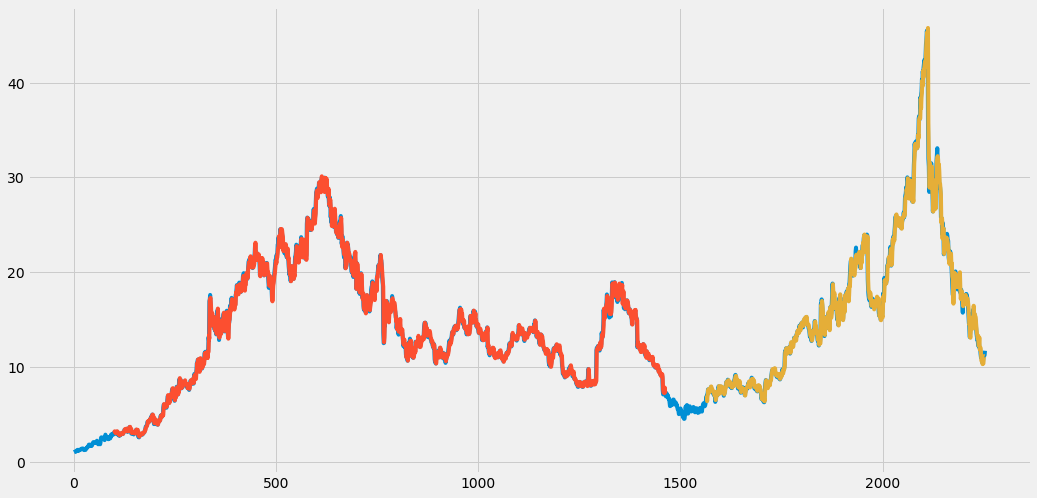

In [110]:
### Plotting
#Shift train predictions for plotting
plt.figure(figsize=(16,8))
look_back = 100
trainPredictPlot = numpy.empty_like(df2)
trainPredictPlot[:,:] =np.nan
trainPredictPlot[look_back:len(lr_train_predict)+look_back, :] = lr_train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df2)
testPredictPlot[:,:] = numpy.nan
testPredictPlot[len(lr_train_predict)+(look_back*2)+1:len(df2)-1,:] = lr_test_predict
#plot baseline and predictions
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [ ]:
# Сделаем предсказание на 30 дней

In [158]:
len(test_data)
x_input = test_data[689:]
x_input = test_data[689:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
temp_input[:10]

[23.43000030517578,
 23.049999237060547,
 22.57999992370605,
 22.540000915527344,
 23.1299991607666,
 24.049999237060547,
 23.850000381469727,
 23.239999771118164,
 23.32999992370605,
 21.549999237060547]

In [126]:
len(temp_input)

100

In [156]:
#Получаем предсказаие на 30 дней
from numpy import array
lr_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
      #print (temp input)
      x_input=np.array(temp_input[1:])
      #print("{} day input {}".format(i,x_input))
      x_input=x_input.reshape((1,n_steps))
      #print (x_input)
      yhat = lr.predict(x_input)
     # print("{} day output {}".format(i,yhat))
      temp_input.extend(yhat.tolist())
      temp_input = temp_input[1:]
      #print(temp_input)
      lr_output.extend(yhat.tolist())
      i=i+1
    else:
      x_input = x_input.reshape((1 , n_steps))
      yhat = lr.predict(x_input)
     # print(yhat[0])
      temp_input.extend(yhat.tolist())
      #print(len(temp_input))
      lr_output.extend(yhat.tolist())
      i=i+1
# print(lr_output)

In [128]:
df3=df2.tolist()

In [129]:
n = 3
m = 4
lr_output1 = []
for i in range(30):
    lr_output1.append([lr_output[i]] )
print(lr_output1)

[[0.24042402238305943], [0.24291076475633813], [0.2467648875296074], [0.2530512672389769], [0.2521994901926185], [0.25459217127832645], [0.25745152511005476], [0.2557423719261944], [0.25598662073423084], [0.25079985275786265], [0.24359974013027694], [0.24108206066522242], [0.23812904005251467], [0.23408524177331505], [0.23079316323358454], [0.2307511062939715], [0.233726870193777], [0.23658153292094222], [0.23951098928502887], [0.23756064551744818], [0.24006378482583848], [0.23842505839562558], [0.23728480850836764], [0.23754587831193483], [0.23494003026950624], [0.23231548929161533], [0.23392553230988483], [0.23898460668922142], [0.24097967747526475], [0.24294258207195296]]


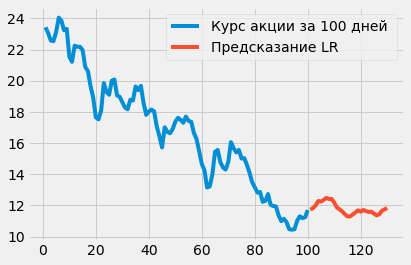

In [130]:
plt.plot(day_new,scaler.inverse_transform(df2[2154:]),label='Курс акции за 100 дней ')
plt.plot(day_pred,scaler.inverse_transform(lr_output1),label='Предсказание LR')
#plt.plot(day_pred,scaler.inverse_transform(lst_output))
#df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
#plt.plot(scaler.inverse_transform(df1[2154:]))
plt.legend()

In [152]:
# Вычислим MAPE для предсказания алгоритмом LR на последних 30 днях
mean_absolute_percentage_error(df_30_1,scaler.inverse_transform(lr_output1))

0.055416981028294114

#CatBoostRegressor

In [133]:
#Так как CatBoost не требует нормализации вернемся к исходным данным
df1 = df.reset_index()['Close']
df3 = df1[:2254]
df3 = np.array(df3).reshape(-1,1)

training_size=int(len(df3)*0.65)
test_size=len(df3)-training_size
train_data,test_data=df3[0:training_size],df3[training_size:len(df3)]

In [134]:
# Построим датасет X=t,t+1,t+2,t+3.... and Y=t+4
import numpy as np
time_step = 100
X_train,y_train = create_dataset(train_data,time_step)
X_test,y_test = create_dataset(test_data,time_step)

In [135]:
print(X_train)

[[ 1.00300002  1.02499998  1.02499998 ...  2.86100006  2.85700011
   2.98399997]
 [ 1.02499998  1.02499998  1.01300001 ...  2.85700011  2.98399997
   3.11199999]
 [ 1.02499998  1.01300001  1.02499998 ...  2.98399997  3.11199999
   3.03699994]
 ...
 [16.62000084 16.13999939 16.07999992 ...  7.1500001   7.1500001
   7.5       ]
 [16.13999939 16.07999992 16.47999954 ...  7.1500001   7.5
   7.30999994]
 [16.07999992 16.47999954 16.44000053 ...  7.5         7.30999994
   7.30000019]]


In [136]:
print(y_train)

[3.11199999 3.03699994 2.9849999  ... 7.30999994 7.30000019 7.        ]


In [137]:
print(X_train.shape), print(y_train.shape)

(1364, 100)
(1364,)


(None, None)

In [138]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          learning_rate = 0.05,
                          random_seed = 42,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

0:	learn: 0.5216037	test: 0.3896732	best: 0.3896732 (0)	total: 87.9ms	remaining: 7m 19s
100:	learn: 0.0417955	test: 0.0758815	best: 0.0757481 (96)	total: 2.88s	remaining: 2m 19s
200:	learn: 0.0310691	test: 0.0726941	best: 0.0726941 (200)	total: 5.67s	remaining: 2m 15s
300:	learn: 0.0255494	test: 0.0712334	best: 0.0709609 (286)	total: 8.52s	remaining: 2m 12s
400:	learn: 0.0219894	test: 0.0704927	best: 0.0703662 (384)	total: 11.2s	remaining: 2m 8s
500:	learn: 0.0193187	test: 0.0705042	best: 0.0700998 (423)	total: 14s	remaining: 2m 6s
600:	learn: 0.0173093	test: 0.0710008	best: 0.0700998 (423)	total: 17.5s	remaining: 2m 7s
700:	learn: 0.0154005	test: 0.0714451	best: 0.0700998 (423)	total: 22.4s	remaining: 2m 17s
800:	learn: 0.0137439	test: 0.0717249	best: 0.0700998 (423)	total: 25.3s	remaining: 2m 12s
900:	learn: 0.0124222	test: 0.0717464	best: 0.0700998 (423)	total: 28s	remaining: 2m 7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.07009984916
bestIteration = 423



In [139]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [140]:
type(train_predict)

numpy.ndarray

In [141]:
train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

In [142]:
train_predict[:10]

array([[2.94603562],
       [2.9893942 ],
       [3.05602285],
       [3.01193635],
       [2.90732067],
       [2.89218804],
       [3.00670111],
       [3.06709329],
       [3.14295495],
       [3.03572372]])

In [143]:
y_train

array([3.11199999, 3.03699994, 2.9849999 , ..., 7.30999994, 7.30000019,
       7.        ])

In [145]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.33840021566882617

In [146]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

2.9709438177586858

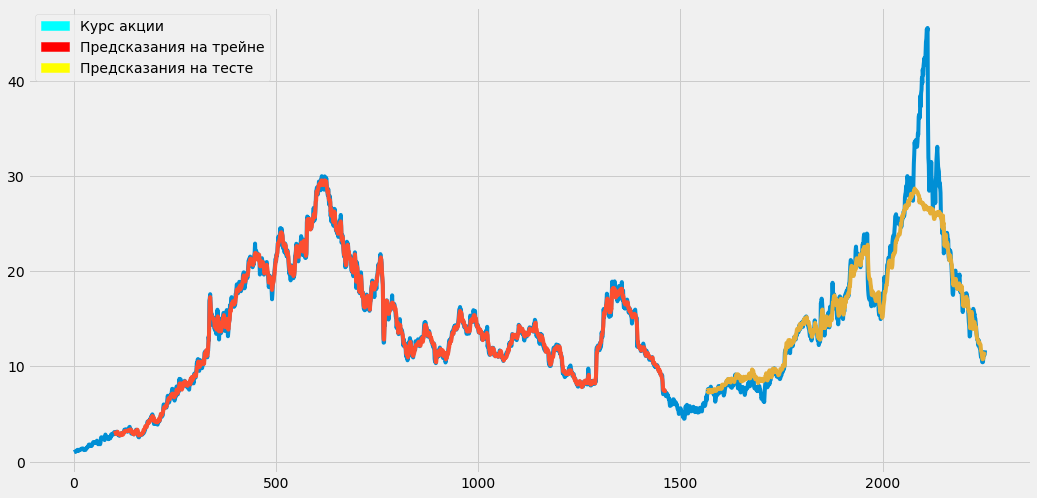

In [147]:
### Plotting
#Shift train predictions for plotting
plt.figure(figsize=(16,8))
look_back = 100
trainPredictPlot = numpy.empty_like(df3)
trainPredictPlot[:,:] =np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df3)
testPredictPlot[:,:] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df3)-1,:] = test_predict
#plot baseline and predictions
plt.plot(df3)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)


import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='cyan', label='Курс акции')
red_patch = mpatches.Patch(color='red', label='Предсказания на трейне')
yellow_patch = mpatches.Patch(color='yellow', label='Предсказания на тесте')
plt.legend(handles=[blue_patch,red_patch,yellow_patch])
plt.show()

In [ ]:
# Сделаем предсказание на 30 дней

In [148]:
len(test_data)
x_input = test_data[689:]
x_input = test_data[689:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
#temp_input

In [157]:
#Получаем предсказаие на 30 дней
from numpy import array
cat_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
      #print (temp input)
      x_input=np.array(temp_input[1:])
     # print("{} day input {}".format(i,x_input))
      x_input=x_input.reshape((1,n_steps))
      #print (x_input)
      yhat = model.predict(x_input)
      #print("{} day output {}".format(i,yhat))
      temp_input.extend(yhat.tolist())
      temp_input = temp_input[1:]
      #print(temp_input)
      cat_output.extend(yhat.tolist())
      i=i+1
    else:
      x_input = x_input.reshape((1 , n_steps))
      yhat = model.predict(x_input)
     # print(yhat[0])
      temp_input.extend(yhat.tolist())
     # print(len(temp_input))
      cat_output.extend(yhat.tolist())
      i=i+1
#print(cat_output)

In [150]:
n = 3
m = 4
cat_output1 = []
for i in range(30):
    cat_output1.append([cat_output[i]] )
print(cat_output1)

[[11.98657867542566], [12.069815345186461], [12.30609290087592], [12.00687661906391], [11.851630280006376], [11.759893374477452], [11.766827587873811], [11.807086204660667], [11.851069703584765], [11.79929649390304], [11.734990593774082], [11.731770585668823], [11.820554923083469], [11.892837676464282], [11.864822555530257], [11.937438017930774], [11.994104868843396], [11.796292263499899], [11.892264774975537], [11.878365591573278], [11.878084053642855], [11.800983533579187], [11.898094583060525], [11.760378622562609], [11.710182684607751], [11.75504331541438], [11.824451501808305], [11.861519946363996], [11.89810702563641], [11.921873937304472]]


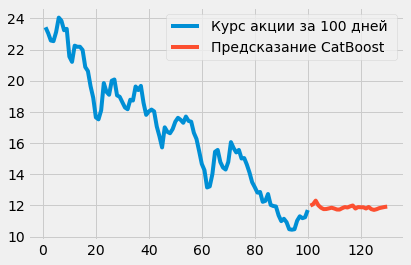

In [151]:
plt.plot(day_new,df3[2154:],label='Курс акции за 100 дней ')
plt.plot(day_pred,cat_output1,label='Предсказание CatBoost')
#plt.plot(day_pred,scaler.inverse_transform(lst_output))
#df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
#plt.plot(scaler.inverse_transform(df1[2154:]))
plt.legend()

In [154]:
# Вычислим MAPE для предсказания алгоритмом CAT на последних 30 днях
mean_absolute_percentage_error(df_30_1,cat_output1)

0.06926176974560781

#График сравнения предсказаний LSTM+LR

In [ ]:
df1 = np.array(df1).reshape(-1,1)

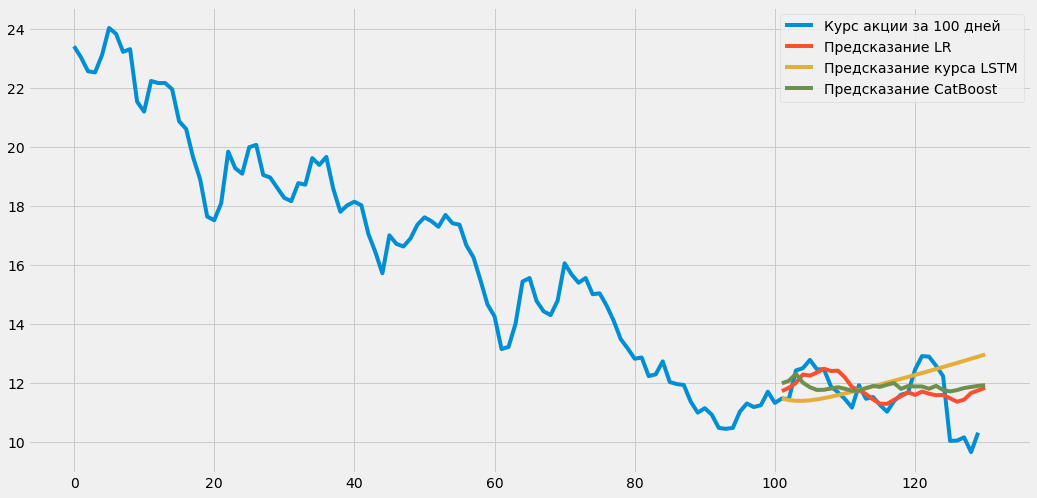

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df1[2154:],label='Курс акции за 100 дней ')
plt.plot(day_pred,scaler.inverse_transform(lr_output1),label='Предсказание LR')
plt.plot(day_pred,scaler.inverse_transform(lst_output),label='Предсказание курса LSTM')
plt.plot(day_pred,cat_output1,label='Предсказание CatBoost')
plt.legend()